In [1]:
import pandas as pd #Pandas 모듈 불러오기
import numpy as np
import openpyxl
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
tqdm.pandas()
plt.rc('font', family='Malgun Gothic')

In [ ]:
data_가맹 = pd.read_csv('../Data/Preprocessed/사용자분석.csv', encoding='utf-8')
data_가맹.head()

In [3]:
#전처리1. 부여군만 필터링
data_가맹_부여 = data_가맹.loc[data_가맹['시']=='부여군']

이상치 확인

In [ ]:
#사용자코드별 사용금액 합산
grp_out =  data_가맹_부여.groupby(['사용자코드','연령대'])['사용금액'].sum().reset_index()
grp_out.head(5)

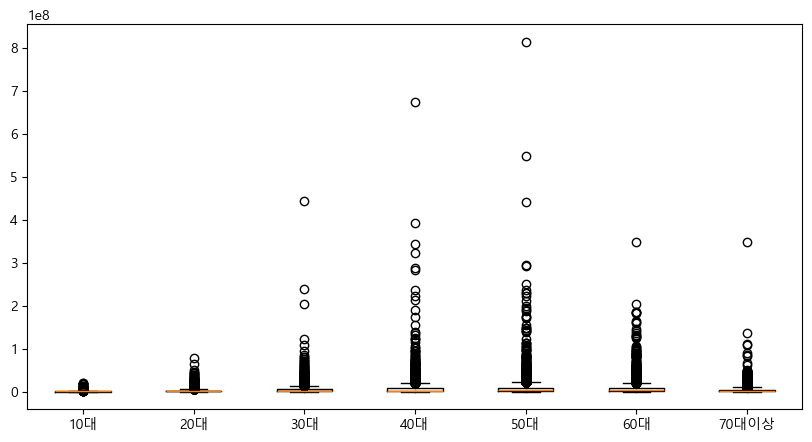

In [5]:
#연령대별 boxplot을 이용해 이상치가 어디서 많이 잡히는 지 시각적으로 확인
plt.figure(figsize=(10,5))
plt.boxplot([grp_out.loc[grp_out['연령대']=='10대','사용금액'], grp_out.loc[grp_out['연령대']=='20대','사용금액'], grp_out.loc[grp_out['연령대']=='30대','사용금액'] , grp_out.loc[grp_out['연령대']=='40대','사용금액'], grp_out.loc[grp_out['연령대']=='50대','사용금액'],grp_out.loc[grp_out['연령대']=='60대','사용금액'], grp_out.loc[grp_out['연령대']=='70대이상','사용금액']])
plt.xticks([1,2,3,4,5,6,7],['10대','20대','30대','40대','50대','60대','70대이상'])
plt.show()

In [1]:
#이상치 처리 함수 정의
def outlier(x, target_column):
    q1 = x[target_column].quantile(0.25)
    q3 = x[target_column].quantile(0.75)
    iqr = q3-q1

    x.loc[((q1 - iqr*1.5) < x[target_column]) & (x[target_column] < (q3 + iqr*1.5)), f'이상치_{target_column}'] = '정상'
    return x

In [7]:
#함수 한 행씩 apply 하기
no_outlier_grp = grp_out.groupby('연령대').progress_apply(lambda x : outlier(x, '사용금액')).reset_index(drop = True)

100%|██████████| 7/7 [00:00<00:00, 164.13it/s]


In [8]:
#기존 데이터의 연령대별 사용자 수와 사용금액 평균
grp_out.groupby('연령대').agg({'사용자코드':'count','사용금액':'mean'})

,사용자코드,사용금액
연령대,,
10대,1586,9.227188e+05
20대,4427,2.401072e+06
30대,5196,4.945088e+06
40대,8136,7.261544e+06
50대,12257,7.595709e+06
60대,15513,7.148848e+06
70대이상,19255,4.206780e+06


In [9]:
#삭제 이후 이터의 연령대별 사용자 수와 사용금액 평균
no_outlier_grp.loc[no_outlier_grp['이상치_사용금액'] == '정상'].groupby('연령대').agg({'사용자코드':'count','사용금액':'mean'})
#평균 사용금액이 낮아진 것을 확인함

,사용자코드,사용금액
연령대,,
10대,1440,4.650148e+05
20대,3940,1.182165e+06
30대,4686,2.718751e+06
40대,7360,4.135870e+06
50대,11151,4.553363e+06
60대,14010,4.322113e+06
70대이상,17322,2.483918e+06


In [10]:
#삭제된 데이터의 사용자 수와 사용금액 평균 확인
no_outlier_grp.loc[no_outlier_grp['이상치_사용금액'] != '정상'].groupby('연령대').agg({'사용자코드':'count','사용금액':'mean'})

,사용자코드,사용금액
연령대,,
10대,146,5.437059e+06
20대,487,1.226246e+07
30대,510,2.540119e+07
40대,776,3.690711e+07
50대,1106,3.826949e+07
60대,1503,3.349786e+07
70대이상,1933,1.964569e+07


In [11]:
#이상치 제거한 변수 정의
data_가맹_부여_이상치제거 = data_가맹_부여.loc[data_가맹_부여['사용자코드'].isin(no_outlier_grp.loc[no_outlier_grp['이상치_사용금액'] == '정상','사용자코드'])]

In [12]:
#전처리2. 대분류 기타 제거
data_가맹_부여_기타제거 = data_가맹_부여_이상치제거.loc[data_가맹_부여_이상치제거['대분류']!='기타' ]

In [13]:
#전처리3. 대분류 + _//_ + 소분류 구분 파생변수 생성
data_가맹_부여_기타제거['소분류_pp'] = data_가맹_부여_기타제거['대분류'] + "_//_"+ data_가맹_부여_기타제거['소분류']

C:\Users\addmin\AppData\Local\Temp\ipykernel_18120\3448087450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_가맹_부여_기타제거['소분류_pp'] = data_가맹_부여_기타제거['대분류'] + "_//_"+ data_가맹_부여_기타제거['소분류']


In [14]:
#분석행정도 4개 권역 정의
분석행정동 = ['부여읍','규암면','홍산면']

In [15]:
# na값과 분석행정동이 아닌 행정동 기타로 지정
data_가맹_부여_기타제거.loc[(~data_가맹_부여_기타제거['읍/면'].isin(분석행정동)) & (~data_가맹_부여_기타제거['읍/면'].isna()), '읍/면'] = '기타'
data_가맹_부여_기타제거.loc[(~data_가맹_부여_기타제거['가맹점 주소'].isin(분석행정동)) & (~data_가맹_부여_기타제거['가맹점 주소'].isna()), '가맹점 주소'] = '기타'

In [16]:
data_가맹_부여_기타제거['읍/면'].unique()

array(['부여읍', '기타', '규암면', '홍산면'], dtype=object)

In [17]:
data_가맹_부여_기타제거['가맹점 주소'].unique()

array(['부여읍', '규암면', '기타', '홍산면'], dtype=object)

In [18]:
data_가맹_부여_기타제거.groupby(['연령대','시간대명','읍/면','대분류','소분류_pp','가맹점 주소','가맹점명']).agg({'사용금액':'sum'}).reset_index()

,연령대,시간대명,읍/면,대분류,소분류_pp,가맹점 주소,가맹점명,사용금액
0,10대,00시~05:59분,규암면,관광/여가/오락,관광/여가/오락_//_노래방,부여읍,싱어노래연습장,30000
1,10대,00시~05:59분,규암면,관광/여가/오락,관광/여가/오락_//_노래방,부여읍,필노래연습장,20000
2,10대,00시~05:59분,규암면,소매,소매_//_수퍼마켓,규암면,이마트24부여규암,3350
3,10대,00시~05:59분,규암면,소매,소매_//_편의점,부여읍,CU부여대박사비점,10250
4,10대,00시~05:59분,규암면,소매,소매_//_편의점,부여읍,CU부여은산점,9350
...,...,...,...,...,...,...,...,...
75905,70대이상,18시~23시59분,홍산면,자동차,자동차_//_주유소,홍산면,홍산주유소,3645300
75906,70대이상,18시~23시59분,홍산면,자동차,자동차_//_충전소,부여읍,용정LPG충전소,520558
75907,70대이상,18시~23시59분,홍산면,자동차,자동차_//_충전소,홍산면,충남가스충전소,357584
75908,70대이상,18시~23시59분,홍산면,종교,종교_//_교회,부여읍,교회서림,34000


In [19]:
data_가맹_부여_기타제거.groupby(['연령대','시간대명','읍/면','대분류','소분류_pp','가맹점 주소','가맹점명']).agg({'사용금액':'sum'}).reset_index().to_excel('../Result/600. 라이프 스타일 분석/1. 라이프 스테이지 EDA_new.xlsx',index=False)